In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import tensorflow as tf

In [2]:
# Load the dataset
file_path = r'C:\Users\maghr\OneDrive\Documents\Big Data\projets\PINN_notebook\Full_dataset.xlsx'
data = pd.read_excel(file_path)


In [49]:
# Define input and output columns
input_columns = ['Net Volume', 'Pulp Area', 'Froth surface area', 'Froth thickness', 'Air Flow rate', 'R_inf Ccp', 'R_inf Gn',
                  'R_inf Po', 'R_inf Sp', 'k_max Ccp', 'k_max Gn', 'k_maxPo', 'k_max Sp', 'Entrainement Savassi parameters',
                    'Total Solids Flow_Feed','Total Liquid Flow_Feed', 'Pulp Volumetric Flow_Feed', 'Solids SG_Feed',
                      'Pulp SG_Feed', 'Solids Fraction_Feed', 'Cu_Feed', 'Fe_Feed', 'Pb_Feed', 'Zn_Feed']
# input_columns = ['Total Solids Flow_Feed', 'Cu_Feed', 'Fe_Feed', 'Pb_Feed', 'Zn_/Feed']


output_columns = ['Total Solids Flow_Concentrate', 
                   'Total Solids Flow_Tailings','Cu_Tails', 'Fe_Tails', 'Pb_Tails', 'Zn_Tails', 
                  'Cu_Concentrate', 'Fe_Concentrate', 'Pb_Concentrate', 'Zn_Concentrate']


In [50]:
# Split data
X = data[input_columns]
y = data[output_columns]
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=(2/9), random_state=42)

# Initialize MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the input data (X)
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

# Fit and transform the output data (y)
y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled = scaler_y.transform(y_val)
y_test_scaled = scaler_y.transform(y_test)

In [96]:
# Model architecture
input_shape = X_train.shape[1]
output_shape = y_train.shape[1]
lambda_physics = 0.9
lambda_prediction = 0.1


In [97]:
input_shape

24

In [98]:
output_shape

10

In [99]:
def predict_loss(y_true, y_pred):
    
# Extracting indices from the output_columns list
    cu_concentrate_index = output_columns.index('Cu_Concentrate')
    # print(cu_concentrate_index)
    cu_tails_index = output_columns.index('Cu_Tails')
    fe_concentrate_index = output_columns.index('Fe_Concentrate')
    fe_tails_index = output_columns.index('Fe_Tails')
    pb_concentrate_index = output_columns.index('Pb_Concentrate')
    pb_tails_index = output_columns.index('Pb_Tails')
    zn_concentrate_index = output_columns.index('Zn_Concentrate')
    zn_tails_index = output_columns.index('Zn_Tails')
    total_solid_flow_concentrate_index = output_columns.index('Total Solids Flow_Concentrate')
    total_solid_flow_tailings_index = output_columns.index('Total Solids Flow_Tailings')


    # Extracting predicted and actual values using the indices
    Cu_concentrate_pred = y_pred[:, cu_concentrate_index]
    Cu_tailing_pred = y_pred[:, cu_tails_index]
    Fe_concentrate_pred = y_pred[:, fe_concentrate_index]
    Fe_tailing_pred = y_pred[:, fe_tails_index]
    Pb_concentrate_pred = y_pred[:, pb_concentrate_index]
    Pb_tailing_pred = y_pred[:, pb_tails_index]
    Zn_concentrate_pred = y_pred[:, zn_concentrate_index]
    Zn_tailing_pred = y_pred[:, zn_tails_index]
    TotalSolidFlow_concentrate_pred = y_pred[:, total_solid_flow_concentrate_index]
    TotalSolidFlow_tailing_pred = y_pred[:, total_solid_flow_tailings_index]

    Cu_concentrate_true = y_true[:, cu_concentrate_index]
    Cu_tailing_true = y_true[:, cu_tails_index]
    # tf.print("y_trueCUconce:", Cu_concentrate_true )
    Fe_concentrate_true = y_true[:, fe_concentrate_index]
    Fe_tailing_true = y_true[:, fe_tails_index]
    Pb_concentrate_true = y_true[:, pb_concentrate_index]
    Pb_tailing_true = y_true[:, pb_tails_index]
    Zn_concentrate_true = y_true[:, zn_concentrate_index]
    Zn_tailing_true = y_true[:, zn_tails_index]
    TotalSolidFlow_concentrate_true = y_true[:, total_solid_flow_concentrate_index]
    TotalSolidFlow_tailing_true = y_true[:, total_solid_flow_tailings_index]
    # tf.print("y_pred:", y_pred)
    # tf.print("y_true:", y_true )
    def mineral_loss(concentrate_pred, concentrate_true, tailing_pred, tailing_true, total_solid_concentrate_pred, total_solid_concentrate_true, total_solid_tailing_pred, total_solid_tailing_true):
        loss_concentrate = tf.square((concentrate_pred * total_solid_concentrate_pred / 100) - (concentrate_true * total_solid_concentrate_true / 100))
        loss_tailing = tf.square((tailing_pred * total_solid_tailing_pred / 100) - (tailing_true * total_solid_tailing_true / 100))
        loss_total_solid_concentrate = tf.square(total_solid_concentrate_pred - total_solid_concentrate_true)
        loss_total_solid_tailing = tf.square(total_solid_tailing_pred - total_solid_tailing_true)

        return loss_concentrate + loss_tailing + loss_total_solid_concentrate + loss_total_solid_tailing
    

    # Calculate the loss for each mineral
    loss_Cu = mineral_loss(Cu_concentrate_pred, Cu_concentrate_true, Cu_tailing_pred, Cu_tailing_true, TotalSolidFlow_concentrate_pred, TotalSolidFlow_concentrate_true, TotalSolidFlow_tailing_pred, TotalSolidFlow_tailing_true)
    loss_Fe = mineral_loss(Fe_concentrate_pred, Fe_concentrate_true, Fe_tailing_pred, Fe_tailing_true, TotalSolidFlow_concentrate_pred, TotalSolidFlow_concentrate_true, TotalSolidFlow_tailing_pred, TotalSolidFlow_tailing_true)
    loss_Pb = mineral_loss(Pb_concentrate_pred, Pb_concentrate_true, Pb_tailing_pred, Pb_tailing_true, TotalSolidFlow_concentrate_pred, TotalSolidFlow_concentrate_true, TotalSolidFlow_tailing_pred, TotalSolidFlow_tailing_true)
    loss_Zn = mineral_loss(Zn_concentrate_pred, Zn_concentrate_true, Zn_tailing_pred, Zn_tailing_true, TotalSolidFlow_concentrate_pred, TotalSolidFlow_concentrate_true, TotalSolidFlow_tailing_pred, TotalSolidFlow_tailing_true)
    
    # Sum the losses for all minerals
    total_predict_loss = loss_Cu + loss_Zn + loss_Fe + loss_Pb
    return total_predict_loss

In [100]:


def physics_loss(y_true):
    # Extracting indices from the output_columns list for true values
    total_solid_flow_feed_index = min(input_columns.index('Total Solids Flow_Feed'), y_true.shape[1] - 1)
    total_solid_flow_tailings_index = output_columns.index('Total Solids Flow_Tailings')
    total_solid_flow_concentrate_index = output_columns.index('Total Solids Flow_Concentrate')
    cu_feed_index = min(input_columns.index('Cu_Feed'), y_true.shape[1] - 1)
    cu_tails_index = output_columns.index('Cu_Tails')
    cu_concentrate_index = output_columns.index('Cu_Concentrate')
    fe_feed_index = min(input_columns.index('Fe_Feed'), y_true.shape[1] - 1)
    fe_tails_index = output_columns.index('Fe_Tails')
    fe_concentrate_index = output_columns.index('Fe_Concentrate')
    pb_feed_index = min(input_columns.index('Pb_Feed'), y_true.shape[1] - 1)
    pb_tails_index = output_columns.index('Pb_Tails')
    pb_concentrate_index = output_columns.index('Pb_Concentrate')
    zn_feed_index = min(input_columns.index('Zn_Feed'), y_true.shape[1] - 1)
    zn_tails_index = output_columns.index('Zn_Tails')
    zn_concentrate_index = output_columns.index('Zn_Concentrate')

    # Extracting true values using the indices
    TotalSolidFlow_feed_true = y_true[:, total_solid_flow_feed_index]
    TotalSolidFlow_tailings_true = y_true[:, total_solid_flow_tailings_index]
    TotalSolidFlow_concentrate_true = y_true[:, total_solid_flow_concentrate_index]
    Cu_feed_true = y_true[:, cu_feed_index]
    Cu_tailings_true = y_true[:, cu_tails_index]
    Cu_concentrate_true = y_true[:, cu_concentrate_index]
    Fe_feed_true = y_true[:, fe_feed_index]
    Fe_tailings_true = y_true[:, fe_tails_index]
    Fe_concentrate_true = y_true[:, fe_concentrate_index]
    Pb_feed_true = y_true[:, pb_feed_index]
    Pb_tailings_true = y_true[:, pb_tails_index]
    Pb_concentrate_true = y_true[:, pb_concentrate_index]
    Zn_feed_true = y_true[:, zn_feed_index]
    Zn_tailings_true = y_true[:, zn_tails_index]
    Zn_concentrate_true = y_true[:, zn_concentrate_index]
    loss_Cu = tf.square((Cu_feed_true * TotalSolidFlow_feed_true / 100) - ((Cu_tailings_true * TotalSolidFlow_tailings_true / 100) + (Cu_concentrate_true * TotalSolidFlow_concentrate_true / 100)))
    loss_Fe = tf.square((Fe_feed_true * TotalSolidFlow_feed_true / 100) - ((Fe_tailings_true * TotalSolidFlow_tailings_true / 100) + (Fe_concentrate_true * TotalSolidFlow_concentrate_true / 100)))
    loss_Pb = tf.square((Pb_feed_true * TotalSolidFlow_feed_true / 100) - ((Pb_tailings_true * TotalSolidFlow_tailings_true / 100) + (Pb_concentrate_true * TotalSolidFlow_concentrate_true / 100)))
    loss_Zn = tf.square((Zn_feed_true * TotalSolidFlow_feed_true / 100) - ((Zn_tailings_true * TotalSolidFlow_tailings_true / 100) + (Zn_concentrate_true * TotalSolidFlow_concentrate_true / 100)))
    # print(loss_Cu)
    # tf.print("y_true:", y_true)

    # Combine the physics-based losses for all minerals
    total_physics_loss = loss_Cu + loss_Fe + loss_Pb + loss_Zn
    return total_physics_loss

In [101]:
def total_loss_function(y_true, y_pred):
    total_predict_loss = predict_loss(y_true, y_pred)
    total_physics_loss = physics_loss(y_true)
    total_loss = (lambda_physics * total_physics_loss) + (lambda_prediction * total_predict_loss)
    return total_loss

In [102]:
input_layer = Input(shape=(input_shape,))
x = Dense(128, activation='relu')(input_layer)  # Input layer
x = Dense(256, activation='relu')(x)           # 1st hidden layer
x = Dense(512, activation='relu')(x)           # 2nd hidden layer
x = Dense(1024, activation='relu')(x)          # 3rd hidden layer
output_layer = Dense(len(output_columns), activation='linear')(x)  # Adjust this to match the number of output columns

# input_layer = Input(shape=(input_shape,))
# x = Dense(128, activation='tanh')(input_layer)  # Input layer
# x = Dense(256, activation='tanh')(x)           # 1st hidden layer
# x = Dense(512, activation='tanh')(x)           # 2nd hidden layer
# x = Dense(1024, activation='tanh')(x)          # 3rd hidden layer
# output_layer = Dense(output_shape, activation='linear')(x)  # Output layer



In [103]:


model = Model(inputs=input_layer, outputs=output_layer)

In [104]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=total_loss_function, metrics='Accuracy')


In [78]:
historyT = model.fit(X_train_scaled, y_train_scaled, validation_data=(X_val_scaled, y_val_scaled),epochs=500)


Epoch 1/500
84/84 [==============================] - 10s 39ms/step - loss: 4.4358 - Accuracy: 0.2201 - val_loss: 0.0308 - val_Accuracy: 0.2799
Epoch 2/500
84/84 [==============================] - 3s 34ms/step - loss: 0.0286 - Accuracy: 0.3042 - val_loss: 0.0142 - val_Accuracy: 0.3127
Epoch 3/500
84/84 [==============================] - 3s 32ms/step - loss: 0.0133 - Accuracy: 0.3305 - val_loss: 0.0224 - val_Accuracy: 0.3574
Epoch 4/500
84/84 [==============================] - 3s 32ms/step - loss: 0.0098 - Accuracy: 0.3372 - val_loss: 0.0071 - val_Accuracy: 0.3561
Epoch 5/500
84/84 [==============================] - 2s 29ms/step - loss: 0.0069 - Accuracy: 0.3522 - val_loss: 0.0061 - val_Accuracy: 0.3719
Epoch 6/500
84/84 [==============================] - 3s 30ms/step - loss: 0.0059 - Accuracy: 0.3597 - val_loss: 0.0049 - val_Accuracy: 0.3784
Epoch 7/500
84/84 [==============================] - 2s 29ms/step - loss: 0.0052 - Accuracy: 0.3579 - val_loss: 0.0070 - val_Accuracy: 0.3640
Epoch

In [106]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_modelPred500.h5', monitor='val_loss', save_best_only=True)

history1 = model.fit(X_train_scaled, y_train_scaled, validation_data=(X_val_scaled, y_val_scaled),
                    epochs=500, callbacks=[early_stopping, model_checkpoint])


Epoch 1/500
84/84 [==============================] - 1s 18ms/step - loss: 0.0025 - Accuracy: 0.3346 - val_loss: 0.0015 - val_Accuracy: 0.3403
Epoch 2/500
84/84 [==============================] - 1s 18ms/step - loss: 0.0014 - Accuracy: 0.3395 - val_loss: 0.0012 - val_Accuracy: 0.3325
Epoch 3/500
84/84 [==============================] - 2s 19ms/step - loss: 0.0015 - Accuracy: 0.3398 - val_loss: 0.0015 - val_Accuracy: 0.3561
Epoch 4/500
84/84 [==============================] - 1s 16ms/step - loss: 0.0012 - Accuracy: 0.3417 - val_loss: 0.0014 - val_Accuracy: 0.3679
Epoch 5/500
84/84 [==============================] - 1s 17ms/step - loss: 0.0012 - Accuracy: 0.3425 - val_loss: 0.0012 - val_Accuracy: 0.3548
Epoch 6/500
84/84 [==============================] - 2s 18ms/step - loss: 6.6797e-04 - Accuracy: 0.3511 - val_loss: 4.6236e-04 - val_Accuracy: 0.3509
Epoch 7/500
84/84 [==============================] - 1s 16ms/step - loss: 5.0006e-04 - Accuracy: 0.3549 - val_loss: 7.0674e-04 - val_Accurac

In [107]:
# best_modelA= tf.keras.models.load_model('best_modela.h5', custom_objects={'total_loss_function': total_loss_function})
y_test_pred_scaled = model.predict(X_test_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)


12/12 [==============================] - 0s 7ms/step


In [53]:
y_test

,Total Solids Flow_Concentrate,Total Solids Flow_Tailings,Cu_Tails,Fe_Tails,Pb_Tails,Zn_Tails,Cu_Concentrate,Fe_Concentrate,Pb_Concentrate,Zn_Concentrate
2014,321.277794,91.913367,3.877782,19.841467,6.429478,9.794371,5.322058,19.459640,30.540651,6.333264
527,341.367855,114.439065,4.063257,19.101297,7.137738,10.489607,4.669233,15.551373,37.530932,5.942357
478,249.721830,92.119357,4.169189,19.031146,4.092684,9.728415,5.035712,17.538235,33.197211,6.143301
1684,61.907025,88.270661,4.731239,22.264424,2.738228,6.879406,5.838119,20.678163,22.400555,5.252855
1653,58.968723,81.021827,3.422589,21.064611,2.941296,10.923154,4.273590,19.928913,23.317810,7.938129
...,...,...,...,...,...,...,...,...,...,...
1080,330.514152,82.046666,5.033038,22.135906,4.500763,7.135248,5.044595,18.492300,35.620484,4.935209
2564,69.301904,85.341182,4.370904,19.348762,3.408323,8.313208,5.168326,17.556302,24.773259,6.204238
862,332.851039,98.001376,4.318070,20.112517,3.902605,11.477110,5.833442,19.345911,28.951970,7.348339
2208,345.474955,90.497394,5.052613,15.493180,4.571156,12.656511,6.092747,16.267235,34.204651,6.812318


In [80]:
X_test

,Net Volume,Pulp Area,Froth surface area,Froth thickness,Air Flow rate,R_inf Ccp,R_inf Gn,R_inf Po,R_inf Sp,k_max Ccp,...,Total Solids Flow_Feed,Total Liquid Flow_Feed,Pulp Volumetric Flow_Feed,Solids SG_Feed,Pulp SG_Feed,Solids Fraction_Feed,Cu_Feed,Fe_Feed,Pb_Feed,Zn_Feed
2014,60.295910,41.752645,37.577381,20.850229,9.979310,30.180197,78.697154,19.679781,15.661964,1.694448,...,413.191161,655.605715,744.145499,4.772750,1.436274,11.633876,5.000782,19.544576,25.177180,7.103179
527,39.579255,39.679225,35.711303,13.340962,8.527548,29.463456,79.758318,19.483449,16.055934,2.384209,...,455.806919,660.114204,755.926672,4.857685,1.476229,12.412861,4.517091,16.442649,29.900138,7.084031
478,74.823320,32.876450,29.588805,16.165099,9.267705,30.479647,79.166093,19.958770,14.880530,1.427834,...,341.841187,476.428833,550.830008,4.684560,1.485522,13.247624,4.802202,17.940545,25.354124,7.109418
1684,56.247185,31.136481,28.022833,19.219430,9.163836,29.524031,80.670036,18.525955,15.209618,1.461505,...,150.177686,163.996063,200.931881,4.120799,1.563583,18.137406,5.187523,21.610527,10.843535,6.208901
1653,68.548227,35.887352,32.298616,22.096892,11.116597,30.366229,79.755254,21.068642,14.176491,1.613017,...,139.990550,154.608171,188.786475,4.152238,1.560486,17.858525,3.781059,20.586217,11.524569,9.665761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080,74.625145,34.712758,31.241482,21.320908,11.425787,27.674468,79.638842,21.332461,14.933820,1.988014,...,412.560818,683.391275,769.402993,4.913688,1.424419,10.912558,5.042297,19.216910,29.431652,5.372734
2564,63.091520,38.101469,34.291322,15.095530,9.816964,31.463651,81.591301,19.708939,15.182544,0.987981,...,154.643086,156.706428,194.683674,4.123032,1.599258,19.265677,4.728262,18.545487,12.982826,7.368092
862,59.466317,36.358165,32.722349,21.706842,10.560952,29.808806,78.740827,19.368714,15.471187,2.412993,...,430.852416,651.834886,745.189502,4.713967,1.452902,12.265217,5.488756,19.520283,23.254260,8.287466
2208,81.537113,33.741592,30.367433,30.485407,12.468185,30.526359,81.657019,19.368081,14.655859,2.142512,...,435.972349,691.690628,784.309697,4.815033,1.437778,11.544419,5.876840,16.106560,28.053449,8.025432


In [108]:

y_test_scaled_df = pd.DataFrame(y_test_pred, columns=output_columns)
y_test_scaled_df

,Total Solids Flow_Concentrate,Total Solids Flow_Tailings,Cu_Tails,Fe_Tails,Pb_Tails,Zn_Tails,Cu_Concentrate,Fe_Concentrate,Pb_Concentrate,Zn_Concentrate
0,322.580536,92.384499,4.318418,18.584591,4.795500,10.252101,5.254008,17.446392,32.370258,5.762011
1,347.281555,112.825684,4.226645,19.065271,5.194051,10.334233,5.253893,17.088778,33.117786,6.331732
2,285.604828,81.980644,4.122493,18.208979,4.593539,9.770304,5.171039,17.383211,31.108595,5.549874
3,63.282974,89.801788,3.855698,18.746412,3.395491,9.491824,4.915816,14.557428,24.833967,6.705284
4,56.690624,83.778999,3.852165,18.073742,2.970007,9.324373,4.691880,14.580379,23.117743,6.183370
...,...,...,...,...,...,...,...,...,...,...
376,327.696716,81.748322,3.913805,19.463623,5.432650,9.519204,5.437150,16.802694,35.131428,6.028932
377,72.857483,84.186287,4.010791,17.839058,2.773958,9.544034,4.609912,14.865541,22.525723,5.958226
378,333.751831,99.269646,4.496642,18.427340,4.663771,10.632979,5.224047,17.751297,31.866995,5.739261
379,342.332428,89.696457,4.104436,19.396208,5.371769,9.928329,5.429724,17.015779,34.973793,6.066076


In [63]:
model.save('PINN500EP.h5')  # Saves the model in HDF5 file format

c:\Users\maghr\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [64]:
from tensorflow.keras.models import load_model

model = load_model(r'C:\Users\maghr\OneDrive\Documents\Big Data\projets\PINN_notebook\PINN500EP.h5', custom_objects={'total_loss_function': total_loss_function})

In [65]:
y_pred = model.predict(X_train_scaled)
y_test_pred = scaler_y.inverse_transform(y_pred)


84/84 [==============================] - 1s 4ms/step


In [67]:
import pandas as pd

# Assuming y_pred is your predictions array and output_columns are your column names
predictions_df = pd.DataFrame(y_test_pred, columns=output_columns)

# Now you can use the to_excel method
predictions_df

,Total Solids Flow_Concentrate,Total Solids Flow_Tailings,Cu_Tails,Fe_Tails,Pb_Tails,Zn_Tails,Cu_Concentrate,Fe_Concentrate,Pb_Concentrate,Zn_Concentrate
0,329.287598,85.838409,4.401943,19.221107,4.959444,10.037381,5.487308,17.293421,34.284325,6.084352
1,69.612427,87.105026,4.308586,19.210268,2.704384,10.345457,5.092942,17.641790,23.467897,7.624357
2,321.344238,81.906631,4.416780,19.080679,4.991702,9.994049,5.501955,17.269312,34.286610,6.066712
3,61.169369,89.060089,4.296291,19.281721,2.609103,10.377015,5.071957,17.694941,22.906851,7.711910
4,328.791992,95.403915,4.341011,19.664474,5.376546,10.068645,5.539026,17.999084,32.252350,6.398694
...,...,...,...,...,...,...,...,...,...,...
2658,347.113586,90.352463,4.395817,19.337656,4.704726,10.119705,5.432124,17.036903,35.171799,5.985380
2659,343.041656,101.303535,4.321668,19.863228,5.269869,10.142384,5.506777,17.959179,32.487206,6.393246
2660,65.442863,81.266380,4.426708,18.544739,3.117697,10.326519,5.097972,16.926407,24.184650,7.483603
2661,78.309425,92.759216,4.277956,19.460541,2.941715,10.366340,5.121741,17.966759,22.794174,7.737429


In [40]:
predictions_dfff.to_csv('prediction_test.csv')

NameError: name 'predictions_dfff' is not defined

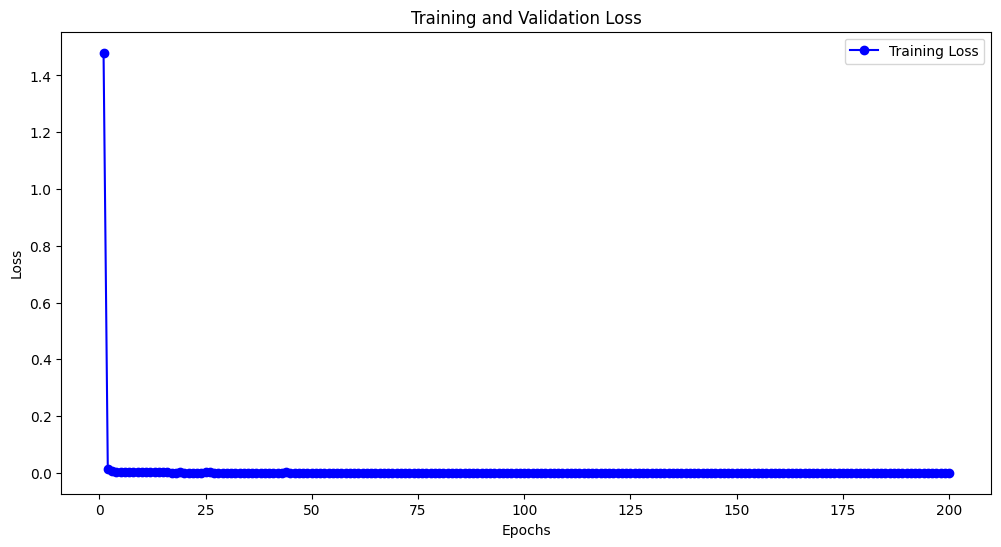

In [40]:
import matplotlib.pyplot as plt

# Extracting loss values from the history object
training_loss = historyT.history['loss']
validation_loss = historyT.history['val_loss']
epochs = range(1, len(training_loss) + 1)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(epochs, training_loss, 'bo-', label='Training Loss')
# plt.plot(epochs, validation_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


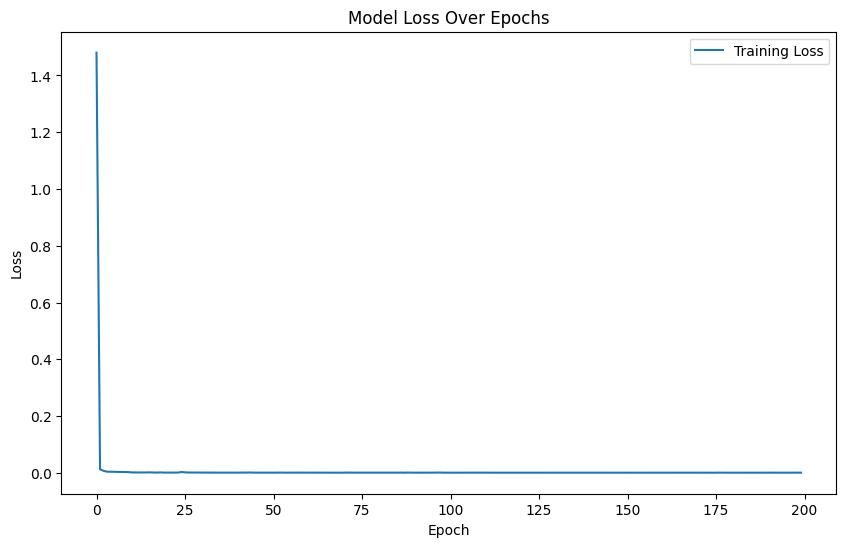

In [60]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(historyT.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [42]:
pip install torch torchdiffeq


^C
Note: you may need to restart the kernel to use updated packages.


     -------------------                    100.6/192.3 MB 4.0 MB/s eta 0:00:23


ERROR: Exception:
Traceback (most recent call last):
  File "c:\Users\maghr\AppData\Local\Programs\Python\Python310\lib\site-packages\pip\_vendor\urllib3\response.py", line 435, in _error_catcher
    yield
  File "c:\Users\maghr\AppData\Local\Programs\Python\Python310\lib\site-packages\pip\_vendor\urllib3\response.py", line 516, in read
    data = self._fp.read(amt) if not fp_closed else b""
  File "c:\Users\maghr\AppData\Local\Programs\Python\Python310\lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 94, in read
    self.__buf.write(data)
  File "c:\Users\maghr\AppData\Local\Programs\Python\Python310\lib\tempfile.py", line 483, in func_wrapper
    return func(*args, **kwargs)
OSError: [Errno 28] No space left on device

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\maghr\AppData\Local\Programs\Python\Python310\lib\site-packages\pip\_internal\cli\base_command.py", line 167, in exc_logging_wrapper

ModuleNotFoundError: No module named 'torch'